In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential,Model
from keras.layers import Dense, Conv2D, Input, MaxPool2D, UpSampling2D, Concatenate, Conv2DTranspose
from keras.optimizers import RMSprop,Adam
from keras import regularizers

import tensorflow as tf 

from scipy.misc import imresize
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
from PIL import Image

from keras.preprocessing.image import array_to_img , img_to_array , load_img ,ImageDataGenerator 

from subprocess import check_output
#print (check_output(["ls", "../myproject"]).decode("utf8"))

Using TensorFlow backend.


In [2]:
data_dir = "train/"
mask_dir = "train_masks/"
all_images = os.listdir(data_dir)

In [3]:
train_images, validation_images = train_test_split(all_images, train_size=0.8, test_size=0.2)
print len(train_images)
#content_image=Image.open('train/fc5f1a3a66cf_06.jpg')
#content_image.size

4070


In [4]:
def grey2rgb_2(img):
    new_img=np.array(list(img)*3)
    new_img=new_img.reshape(img.shape[0],img.shape[1],3)
    return new_img

In [5]:
size=64

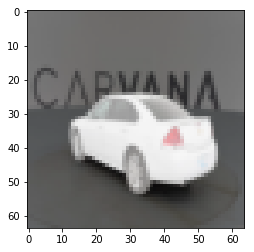

In [6]:
def grey2rgb(img):
    new_img = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            new_img.append(list(img[i][j])*3)
    new_img = np.array(new_img).reshape(img.shape[0], img.shape[1], 3)
    return new_img


# generator that we will use to read the data from the directory
def data_gen_small(data_dir, mask_dir, images, batch_size, dims):
        """
        data_dir: where the actual images are kept
        mask_dir: where the actual masks are kept
        images: the filenames of the images we want to generate batches from
        batch_size: self explanatory
        dims: the dimensions in which we want to rescale our images
        """
        while True:
            batch = np.random.choice(np.arange(len(images)), batch_size)
            imgs = []
            labels = []
            for i in batch:
                # images
                original_img = load_img(data_dir + images[i])
                resized_img = imresize(original_img, dims+[3])
                array_img = img_to_array(resized_img)/255
                imgs.append(array_img)
                
                # masks
                original_mask = load_img(mask_dir + images[i].split(".")[0] + '_mask.gif')
                resized_mask = imresize(original_mask, dims+[3])
                array_mask = img_to_array(resized_mask)/255
                labels.append(array_mask[:, :, 0])
            imgs = np.array(imgs)
            labels = np.array(labels)
            #print labels
            yield imgs, labels.reshape(-1, dims[0], dims[1], 1)

# example use
train_gen = data_gen_small(data_dir, mask_dir, train_images, 5, [size, size])
img, msk = next(train_gen)

plt.imshow(img[0])
plt.imshow(grey2rgb(msk[0]), alpha=0.5)

In [7]:
def down(input_layers,filters,pool=True):
    conv1=Conv2D(filters,(2,2),padding="same",activation='elu')(input_layers)
    residual = Conv2D(filters, (3, 3), padding='same', activation='elu')(conv1)
    if pool:
        max_pool = MaxPool2D()(residual)
        return max_pool, residual
    else:
        return residual

def up(input_layer, residual, filters):
    filters=int(filters)
    upsample = UpSampling2D()(input_layer)
    upconv = Conv2D(filters, kernel_size=(2, 2), padding="same")(upsample)
    concat = Concatenate(axis=3)([residual, upconv])
    conv1 = Conv2D(filters, (3, 3), padding='same', activation='elu')(concat)
    conv2 = Conv2D(filters, (3, 3), padding='same', activation='elu')(conv1)
    return conv2

In [8]:
# Make a custom U-nets implementation.
filters = 64
input_layer = Input(shape = [size,size, 3])
layers = [input_layer]
residuals = []

# Down 1, 128
d1, res1 = down(input_layer, filters)
residuals.append(res1)

filters *= 2

# Down 2, 64
d2, res2 = down(d1, filters)
residuals.append(res2)

filters *= 2

# Down 3, 32
d3, res3 = down(d2, filters)
residuals.append(res3)

filters *= 2

# Down 4, 16
d4, res4 = down(d3, filters)
residuals.append(res4)

filters *= 2

# Down 5, 8
d5 = down(d4, filters, pool=False)

atr1=Conv2D(512,(3,3),dilation_rate=(2, 2),activation='relu',padding='same')(d5)
atr2=Conv2D(512,(3,3),dilation_rate=(2, 2),activation='relu',padding='same')(atr1)
atr3=Conv2D(512,(3,3),dilation_rate=(2, 2),activation='relu',padding='same')(atr2)

# Up 1, 16
up1 = up(atr3, residual=residuals[-1], filters=filters/2)

filters /= 2

# Up 2,  32
up2 = up(up1, residual=residuals[-2], filters=filters/2)

filters /= 2

# Up 3, 64
up3 = up(up2, residual=residuals[-3], filters=filters/2)

filters /= 2

# Up 4, 128
up4 = up(up3, residual=residuals[-4], filters=filters/2)

out = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(up4)

model = Model(input_layer, out)

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 64, 64, 3)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 64, 64, 64)    832         input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 64, 64, 64)    36928       conv2d_1[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 32, 32, 64)    0           conv2d_2[0][0]                   
___________________________________________________________________________________________

In [9]:
from keras.losses import binary_crossentropy
import keras.backend as K


def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_loss(y_true, y_pred):
    return 1 - dice_coeff(y_true, y_pred)


def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


In [10]:
model.compile(optimizer=Adam(1e-4), loss= bce_dice_loss, metrics=[dice_coeff])
model.fit_generator(train_gen, steps_per_epoch=100,epochs=30)

Epoch 1/30
100/100 [==============================] - 48s - loss: 0.3485 - dice_coeff: 0.8172    
Epoch 2/30
100/100 [==============================] - 46s - loss: 0.2209 - dice_coeff: 0.8842    
Epoch 3/30
100/100 [==============================] - 46s - loss: 0.1763 - dice_coeff: 0.9070    
Epoch 4/30
100/100 [==============================] - 45s - loss: 0.1470 - dice_coeff: 0.9220    
Epoch 5/30
100/100 [==============================] - 44s - loss: 0.1331 - dice_coeff: 0.9293    
Epoch 6/30
100/100 [==============================] - 44s - loss: 0.1193 - dice_coeff: 0.9362    
Epoch 7/30
100/100 [==============================] - 44s - loss: 0.1101 - dice_coeff: 0.9411    
Epoch 8/30
100/100 [==============================] - 42s - loss: 0.1043 - dice_coeff: 0.9448    
Epoch 9/30
100/100 [==============================] - 43s - loss: 0.1004 - dice_coeff: 0.9468    
Epoch 10/30
100/100 [==============================] - 42s - loss: 0.0964 - dice_coeff: 0.9487    
Epoch 11/30
100/100

In [11]:
#accuracy = model.evaluate(test_x, test_y, verbose=1)

In [14]:
validation_gen = data_gen_small(data_dir, mask_dir, validation_images, 5, [size, size])
img, msk = next(train_gen)

In [15]:
model.evaluate_generator(validation_gen,100)

[0.074005604237318043, 0.96003065109252927]